In [1]:
!pip install boto3 keras tensorflow pyprind

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 34.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.38 requires botocore==1.27.38, but you have botocore 1.27.43 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.43 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [6]:
import os
import csv
import time
import sys
import random
import tempfile
import pyprind
import boto3
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import losses, layers, optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from PIL import ImageFile
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import load_img, img_to_array, smart_resize

In [7]:
S3_BUCKET = '76f71cf8-ac28-4d72-81a1-28db41a2e7c2'
IMG_SIZE = (320, 320)
classes = ['Cardiomegaly', 'nf']
class_dict = {}
for i, c in enumerate(classes):
    key = np.array([0 for i in range(len(classes))])
    key[i] = 1
    class_dict[c] = key # i
        
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
def load_images(folder):
    '''
    Load num_images images from S3 and return X, y, and filename arrays. -1 is placeholder value.
    Bucket structure:
    $ tree
    .
    |---folder/
        |---train/
        |    |---class_1/
        |    |---class_2/
        |    |---...
        |---test/
             |---class_1/
             |---class_2/
             |---...
    '''
    # set up bucket
    s3 = boto3.client("s3")
    S3_PREFIX = folder
        
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX)

    # get all filenames from bucket
    s3_objects = []
    for page in pages:
        s3_objects += [obj["Key"] for obj in page["Contents"]]
    arr_size = len(s3_objects)
        
    X, y, filenames = [0]*arr_size, [0]*arr_size, [0]*arr_size
    
    # IMPORTANT: there must be a / at the end of Prefix! ex: 'Strictly_Mass_and_NF/test/'
    result = boto3.client("s3").list_objects(Bucket=S3_BUCKET, Prefix=S3_PREFIX, Delimiter='/')
        
    # create temp directory to not clog memory
    # Note: if the train or test folders are too large, may need to break this down into smaller chunks
    with tempfile.TemporaryDirectory() as tempdir:

        # create progress bar
        bar = pyprind.ProgBar(len(s3_objects), title="Loading Images", bar_char='█')
        bar_count = 0

        for i, s3_file in enumerate(s3_objects):
            split_name = s3_file.split('/')
            filename = split_name[-1]
            label = split_name[-2]
            local_file_path = os.path.join(tempdir, split_name[-1])
            s3.download_file(S3_BUCKET, s3_file, local_file_path)
            img = cv2.imread(local_file_path)
            res = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            
#             image_generator = tf.io.read_file(local_file_path) 
#             tensor = tf.io.decode_image(image_generator, channels=3, dtype=tf.dtypes.float32)
#             tensor = tf.image.resize(tensor, [320, 320])
#             img_tensor = tf.expand_dims(tensor, axis=0)
            
#             return res, img_tensor
                
            # store values from each image
            X[i] = res #.reshape((3,)+IMG_SIZE)
            y[i] = class_dict[label]
            filenames[i] = filename

            # update progress bar
            bar_count += 1
            bar.update(item_id=bar_count)
#             if bar_count > num:
#                 break

        print(f"Loaded {bar_count} files.")
        
    # convert to arrays
    X = np.array(X)
    y = np.array(y)
    filenames = np.array(filenames)
        
    return X, y, filenames

data, labels, filenames = load_images('Strictly_Cardiomegaly_and_NF')
print(data.shape, labels.shape)

Loaded 1713 files.
(1713, 320, 320, 3) (1713, 2)


In [9]:
# mini_X_train, mini_y_train = X_train[:100], y_train[:100]
x_train_and_val, x_test, y_train_and_val, y_test = train_test_split(data, labels, test_size=0.1, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train_and_val, y_train_and_val, test_size=0.11, random_state=0)

print('Train size:', x_train.shape[0])
print('Validation size:', x_val.shape[0])
print('Test size:', x_test.shape[0])

Train size: 1371
Validation size: 170
Test size: 172


In [15]:
BATCH_SIZE = 4

datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True,
                                )
def eval_model(model_name):
    model = tf.keras.models.load_model(model_name)
    
    print(model_name)
    
    train_batches = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
    train_eval = model.evaluate_generator(train_batches, steps = len(train_batches))
    print(f'Train loss: {train_eval[0]}, Train accuracy: {train_eval[1]}')

    val_batches = datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
    val_eval = model.evaluate_generator(val_batches, steps = len(val_batches))
    print(f'Validation loss: {val_eval[0]}, Validation accuracy: {val_eval[1]}')

    # val and test have the same transformations
    test_batches = datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
    test_eval = model.evaluate_generator(test_batches, steps = len(test_batches))
    print(f'Test loss: {test_eval[0]}, Test accuracy: {test_eval[1]}')
    
    print()
    
models = ['7_31_multi_catcross_weights.h5', '30_ep_multi_catcross_weights.h5', '50_ep_multi_catcross_weights.h5', 'best_model_v1.h5', 'best_model.h5']
models = ['best_model.h5']
for m in models:
    eval_model(m)
    
    
# special way to load 25_multi_catcross_weights because I didn't save the model architechture...

model = tf.keras.models.load_model('7_31_multi_catcross_weights.h5')
model.load_weights('25_multi_catcross_weights.h5')
    
print('25_multi_catcross_weights.h5')

train_batches = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
train_eval = model.evaluate_generator(train_batches, steps = len(train_batches))
print(f'Train loss: {train_eval[0]}, Train accuracy: {train_eval[1]}')

val_batches = datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
val_eval = model.evaluate_generator(val_batches, steps = len(val_batches))
print(f'Validation loss: {val_eval[0]}, Validation accuracy: {val_eval[1]}')

# val and test have the same transformations
test_batches = datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
test_eval = model.evaluate_generator(test_batches, steps = len(test_batches))
print(f'Test loss: {test_eval[0]}, Test accuracy: {test_eval[1]}')

best_model.h5


/tmp/ipykernel_23633/2303476615.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_eval = model.evaluate_generator(train_batches, steps = len(train_batches))


Train loss: 0.3805922269821167, Train accuracy: 0.8373450040817261


/tmp/ipykernel_23633/2303476615.py:16: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_eval = model.evaluate_generator(val_batches, steps = len(val_batches))


Validation loss: 0.4597252905368805, Validation accuracy: 0.8235294222831726


/tmp/ipykernel_23633/2303476615.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_eval = model.evaluate_generator(test_batches, steps = len(test_batches))


Test loss: 0.49196451902389526, Test accuracy: 0.7732558250427246



In [7]:
def load_image_2(image_dir):
# load image via tf.io
    image_generator = tf.io.read_file(image_dir)  

    # convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
    # set the dtypes to align with pytorch for comparison since it will use uint8 by default
    tensor = tf.io.decode_image(image_generator, channels=3, dtype=tf.dtypes.float32)
    # (384, 470, 3)

    # resize tensor to 320 x 320
    tensor = tf.image.resize(tensor, [320, 320])
    # (320, 320, 3)

    # add another dimension at the front to get NHWC shape
    img_tensor = tf.expand_dims(tensor, axis=0)
    # (1, 320, 320, 3)
    #print(img_tensor)

    # read images in using cv2 instead of tf.io.read_file
#     img = cv2.imread(image_dir)
#     res = cv2.resize(img, dsize=[320, 320], interpolation=cv2.INTER_CUBIC)

    datagen = ImageDataGenerator(
                           samplewise_center=True,
                           samplewise_std_normalization=True,
                           )

    # Note: USING CV2, Which gives slightly diff output than the tensor. If you want to use tensor, swap res with img_tensor[0]
    img_tensor = next(datagen.flow(np.array([img_tensor[0]]), np.array([np.array([1, 0])]), batch_size=1))[0][0]
    img_tensor = np.array([img_tensor])

    return img_tensor


def grad_cam(input_model, image, layer_name, H=320, W=320):
    
#     """GradCAM method for visualizing input saliency."""
#     '''y_c = input_model.output[0, cls]
#         conv_output = input_model.get_layer(layer_name).output
#         grads = K.gradients(y_c, conv_output)[0] ### gradients error? 

#         gradient_function = K.function([input_model.input], [conv_output, grads])

#         output, grads_val = gradient_function([image])
#         output, grads_val = output[0, :], grads_val[0, :, :, :]

#         weights = np.mean(grads_val, axis=(0, 1))
#         cam = np.dot(output, weights)'''

    ### AJ EDITS ###

    #model = load_model(os.path.join(model_folder, "custom_model.h5"))
    #image = image.load_img(image_path) 
    #img_tensor = image.img_to_array(image)
    #print(image) #print(type(image))
    img_tensor = image
    #print(img_tensor)

    preds = input_model.predict(img_tensor)
    model_prediction = input_model.output[:, np.argmax(preds[0])]

    conv_layer = input_model.get_layer(layer_name) 
    heatmap_model = tf.keras.models.Model([input_model.inputs], [conv_layer.output, input_model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = heatmap_model(img_tensor) ### have to edit... img_tensor
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_output)

    castConvOutputs = tf.cast(conv_output > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # My goal was to create the class activation map for single image, so we are skipping axis=0 which is meant to have the batch_size of images at axis=0
    convOutputs = conv_output[0]
    guidedGrads = guidedGrads[0]

    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # Process CAM
    '''cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)'''
    cam = cv2.resize(cam.numpy(), (W, H))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    print(type(cam))
#     print(cam)
    return cam


def compute_gradcam(model, image_dir, label, saved_path, layer_name='bn'):
    pre_processed_input_2 = load_image_2(image_dir)
    predictions = model.predict(pre_processed_input_2)
    with open(image_dir, 'rb') as f:
      image_bytes = f.read()
    # for i in range(len(labels)):
    # heatmap for Cardiomegaly 
    if label == 'Cardiomegaly':
      label_index = 0
    else:
      label_index = 1
    print(f"Generating gradcam for class {label}") 
    gradcam = grad_cam(model, pre_processed_input_2, layer_name) # changed preprocessed_input -> pre_processed_input_2
    plt.title(f"{label}: p={predictions[0][label_index]:.3f}")
    plt.axis('off')
    # plot original image + heatmap
    original_image = tf.keras.preprocessing.image.load_img(image_dir, target_size=(320, 320))
    plt.imshow(original_image, cmap='gray')
    plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][label_index]))
#     plt.savefig(saved_path)
    # returns predicted label confidence/probability
    return predictions[0][label_index]

In [21]:
image_dir = '/home/ec2-user/SageMaker/Cardiomegaly Model/gradcam_train/Cardiomegaly_00000013_045.png'
saved_path = '/home/ec2-user/SageMaker/Cardiomegaly Model /'

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


0.4652023

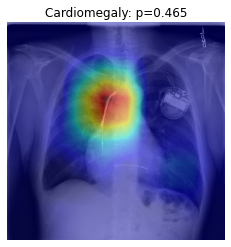

In [10]:
model = tf.keras.models.load_model('7_31_multi_catcross_weights.h5')
compute_gradcam(model, image_dir, 'Cardiomegaly', saved_path, layer_name='bn')

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


0.84639233

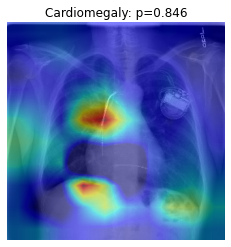

In [11]:
model = tf.keras.models.load_model('7_31_multi_catcross_weights.h5')
model.load_weights('25_multi_catcross_weights.h5')
compute_gradcam(model, image_dir, 'Cardiomegaly', saved_path, layer_name='bn')

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


0.24621382

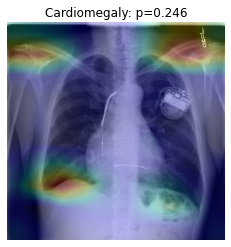

In [12]:
model = tf.keras.models.load_model('30_ep_multi_catcross_weights.h5')
compute_gradcam(model, image_dir, 'Cardiomegaly', saved_path, layer_name='bn')

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


0.7961744

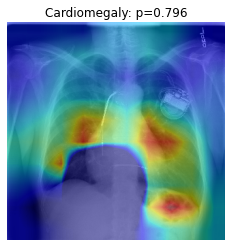

In [13]:
model = tf.keras.models.load_model('50_ep_multi_catcross_weights_v2.h5')
compute_gradcam(model, image_dir, 'Cardiomegaly', saved_path, layer_name='bn')

In [25]:
model = tf.keras.models.load_model('50_ep_multi_catcross_weights.h5')

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


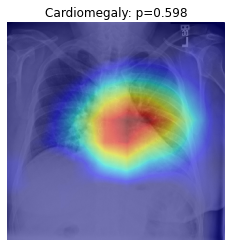

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


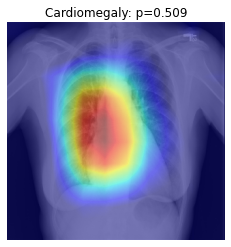

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


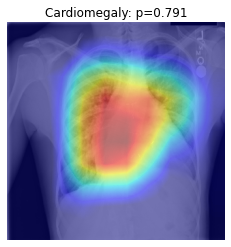

In [27]:
# model = tf.keras.models.load_model('50_ep_multi_catcross_weights.h5')
# compute_gradcam(model, image_dir, 'Cardiomegaly', saved_path, layer_name='bn')
# plt.show()
# path = '/home/ec2-user/SageMaker/Cardiomegaly Model/gradcam_train/'
# compute_gradcam(model, path+'00000131_001.png', 'Cardiomegaly', saved_path, layer_name='bn')
# plt.show()
# compute_gradcam(model, path+'00000200_001.png', 'Cardiomegaly', saved_path, layer_name='bn')
# plt.show()
# compute_gradcam(model, path+'00000211_000.png', 'Cardiomegaly', saved_path, layer_name='bn')
# plt.show()
# compute_gradcam(model, path+'00000211_038.png', 'Cardiomegaly', saved_path, layer_name='bn')
# plt.show()
# compute_gradcam(model, path+'00000211_038.png', 'Cardiomegaly', saved_path, layer_name='bn')
# plt.show()

path = '/home/ec2-user/SageMaker/Cardiomegaly Model/gradcam_test/'
for filename in os.listdir(path):
    compute_gradcam(model, path+filename, 'Cardiomegaly', saved_path, layer_name='bn')
    plt.show()

In [16]:
# model = tf.keras.models.load_model('best_model.h5')
# compute_gradcam(model, image_dir, 'Cardiomegaly', saved_path, layer_name='bn')

Cleanup called...


Generating gradcam for class Cardiomegaly
<class 'numpy.ndarray'>


0.85393375

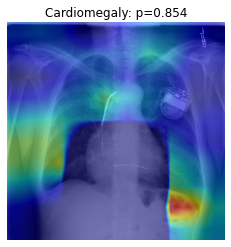

In [17]:
model = tf.keras.models.load_model('best_model_v1.h5')
compute_gradcam(model, image_dir, 'Cardiomegaly', saved_path, layer_name='bn')